# Practice: Graph Isomorphism Network


In this Colab notebook, we will implement the  Graph Isomorphism Network (GIN) ([Xu et al. 2018](https://arxiv.org/abs/1810.00826v3)). We will ustilize the PROTEINS dataset which is popular in bioinformatics.

**Note**: To ensure a smooth workflow, please run all the cells in sequential order. This way, dependencies and intermediate variables will correctly propagate from one cell to the next.

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [147]:
# Install PyTorch
!pip install torch
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-geometric
!pip install ogb

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 1 PyTorch Geometric (Datasets and Data)


PyTorch Geometric generally has two classes for storing or transforming the graphs into tensor format. One is `torch_geometric.datasets`, which contains a variety of common graph datasets. Another one is `torch_geometric.data` that provides the data handling of graphs in PyTorch tensors.

In this section, we will learn how to use the `torch_geometric.datasets` and `torch_geometric.data`.

## PROTEINS Datasets
`torch_geometric.datasets` has many common graph datasets. Here we will explore the usage by using one example dataset. The PROTEINS dataset is a collection of 1113 graphs representing proteins, where nodes are amino acids. Two nodes are connected by an edge when they are close enough (< 0.6 nm). The goal is to classify each protein as an enzyme or not

## Question 1: What is the number of classes and number of features in the PROTEINS dataset?

In [148]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='.', name='PROTEINS').shuffle()

def get_num_classes(dataset):
  # TODO: Implement this function that takes a PyG dataset object
  # and return the number of classes for that dataset.

  num_classes = 0

  ############# Your code here ############
  num_classes = dataset.num_classes

  ##################################

  return num_classes

def get_num_features(dataset):
  # TODO: Implement this function that takes a PyG dataset object
  # and return the number of features for that dataset.

  num_features = 0

  ############# Your code here ############

  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  num_features = dataset.num_features
  #########################################

  return num_features

# You may find that some information need to be stored in the dataset level,
# specifically if there are multiple graphs in the dataset

num_classes = get_num_classes(dataset)
num_features = get_num_features(dataset)
print(f'Dataset: {dataset}')
print("{} dataset has {} classes".format(dataset, num_classes))
print("{} dataset has {} features".format(dataset, num_features))

Dataset: PROTEINS(1113)
PROTEINS(1113) dataset has 2 classes
PROTEINS(1113) dataset has 3 features


## PyG Data

Each PyG dataset usually stores a list of `torch_geometric.data.Data` objects. Each `torch_geometric.data.Data` object usually represents a graph. You can easily get the `Data` object by indexing on the dataset.

For more information such as what will be stored in `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

## Question 2: What is the label of the graph (index 1 and index 2 in the PROTEINS dataset)?

In [149]:
def get_graph_class(dataset, idx):
  # TODO: Implement this function that takes a PyG dataset object,
  # the index of the graph in dataset, and returns the class/label
  # of the graph (in integer).

  label = -1

  ############# Your code here ############
  label = int(dataset[idx].y.item())
  #########################################

  return label

# Here pyg_dataset is a dataset for graph classification
graph_0 = dataset[0]
print(graph_0)
idx_1 = 0
idx_2 = 1
label_1 = get_graph_class(dataset, idx_1)
label_2 = get_graph_class(dataset, idx_2)
print('Graph with index {} has label {}'.format(idx_1, label_1))
print('Graph with index {} has label {}'.format(idx_2, label_2))

Data(edge_index=[2, 220], x=[64, 3], y=[1])
Graph with index 0 has label 0
Graph with index 1 has label 0


## Question 3: What is the number of edges for the graph, number of noeds and how many graphs in the PROTEINS datasets (index 200 in the PROTEINS dataset)?

In [150]:
def get_graph_num_edges(dataset, idx):
  # TODO: Implement this function that takes a PyG dataset object,
  # the index of the graph in dataset, and returns the number of
  # edges in the graph (in integer). You should not count an edge
  # twice if the graph is undirected. For example, in an undirected
  # graph G, if two nodes v and u are connected by an edge, this edge
  # should only be counted once.

  num_edges = 0

  ############# Your code here ############
  ## Note:
  ## 1. You can't return the data.num_edges directly
  ## 2. We assume the graph is undirected
  ## 3. Use .edge_index
  num_edges = int(dataset[idx].num_edges / 2)
  num_nodes = int(dataset[idx].num_nodes)
  num_graphs = int(len(dataset))
  ##################################

  return num_edges, num_nodes, num_graphs

idx = 200
num_edges, num_nodes, num_graphs = get_graph_num_edges(dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))
print('Graph with index {} has {} nodes'.format(idx, num_nodes))
print('The datasets contains {} graphs'.format(num_graphs))


Graph with index 200 has 68 edges
Graph with index 200 has 38 nodes
The datasets contains 1113 graphs


For understanding about protein structures, plot one of graphs to see what it looks.

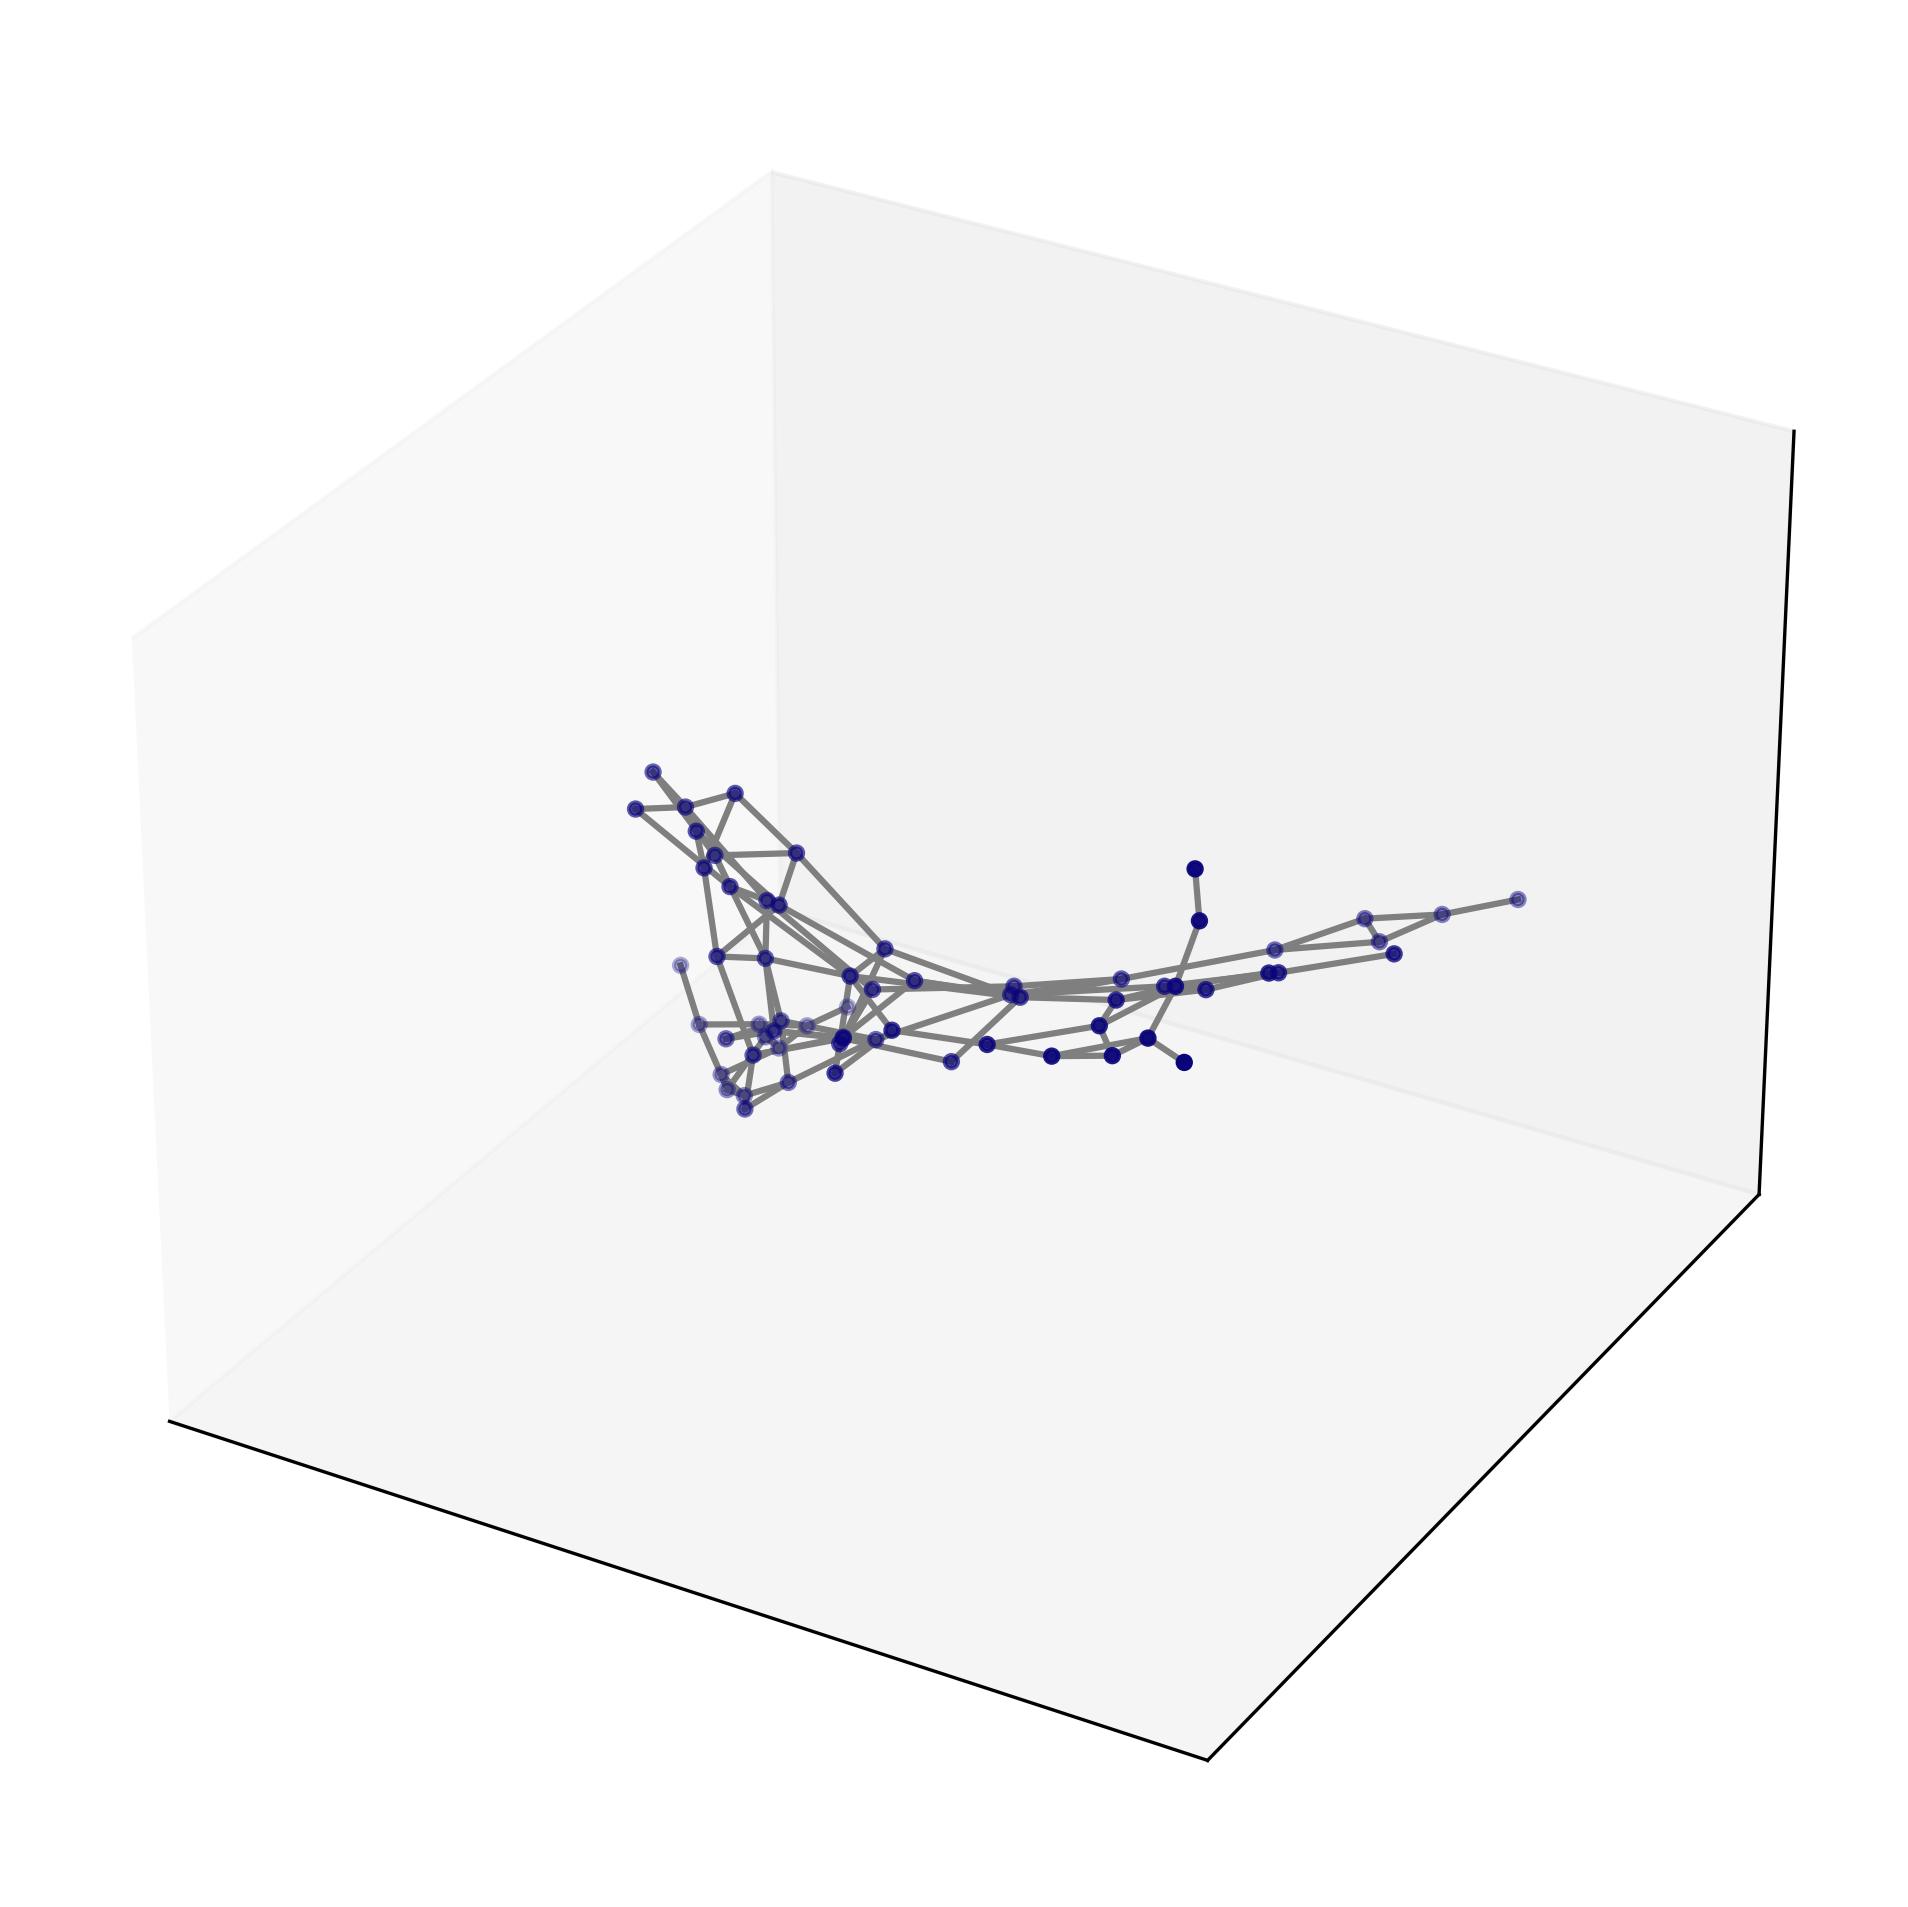

In [151]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np


#########################################
## Note:
## This dataset contains 1113 graphs,
## each of which can be taken by an index of that graph.
## You can view different protein structures by changing
## the index of dataset.
index = 0;
G = to_networkx(dataset[index], to_undirected=True)
#########################################


# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=10, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

##  Data Loader
 Since graphs are a common way to represent molecules, the PROTEINS dataset is also encoded as graphs. This doesn't mean we feed the entire graph directly into the model. Instead, we subset a part of graphs by mini-batching, and we feed this mini-batch to the model.

 Now, let's split the dataset into training set, validation set, test set, and create a data loader for each set.

In [152]:
from torch_geometric.loader import DataLoader

##################Your code here ##################
## Note:
## 1. Create training, validation, and test sets
## 2. Each set is divided into ratios of 0.8, 0.1, and 0.1.
## 3. 0.8(80%, train set), 0.1(10%, validation set), and 0.1(10%, test set).
## 4. The 'int' argument will be needed to minimize errors.
train_idx = int(0.8*len(dataset))
val_idx = int(0.9*len(dataset))
train_dataset = dataset[:train_idx]
val_dataset = dataset[train_idx:val_idx]
test_dataset = dataset[val_idx:]
#############################################

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

##################Your code here ##################
## Note:
## 1. Create mini-batches
## 2. Set the batch size as 64.
## 3. It's essential to shuffle the training and validation batches
##    during each epoch to enhance learning efficiency, though we
##    do not need shuffling for test batches. This aids
##    in preventing overfitting, ensuring uniform learning,
##    among other benefits.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#############################################

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 9260], x=[2540, 3], y=[64], batch=[2540], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 11308], x=[2857, 3], y=[64], batch=[2857], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 10664], x=[2971, 3], y=[64], batch=[2971], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 10052], x=[2534, 3], y=[64], batch=[2534], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 9318], x=[2431, 3], y=[64], batch=[2431], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 9978], x=[2595, 3], y=[64], batch=[2595], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 9282], x=[2512, 3], y=[64], batch=[2512], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 10582], x=[2907, 3], y=[64], batch=[2907], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 7252], x=[1914, 3], y=[64], batch=[1914], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 10328], x=[2875, 3], y=[64], 

# 2 GIN with PyTorch


## GCN
To compare the performance of GIN against GCN, we will use the GCN model as a baseline.




In [153]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN using ModuleList with Batch Normalization."""

    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GCN, self).__init__()
        ############### Your code here ##############
        ## Note:
        ## 1. Create initial convolutional layer
        ## 2. Create `num_layers - 2` hidden convolutional layers
        ## 3. Create final convolutional layer
        ## 4. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 5. self.bns has num_layers - 1 BatchNorm1d layers
        ## 6. You should use torch.nn.LogSoftmax for self.softmax
        ## 7. The only parameter you need to set for BatchNorm1d is 'num_features
        ## 8. (~ 9 lines of code)
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels=input_dim, out_channels=hidden_dim))
        for _ in range(num_layers-1):
          self.convs.append(GCNConv(in_channels=hidden_dim, out_channels=hidden_dim))
          self.bns.append(torch.nn.BatchNorm1d(num_features=hidden_dim))
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.lin = torch.nn.Linear(hidden_dim, num_classes)
        #######################################

    def forward(self, x, edge_index, batch):
        # TODO: Implement this function that takes the feature tensor x,

        ############### Your code here ###############
        ## Note:
        ## 1. Node embeddings with Batch Normalization
        ## 2. For the final convolutional layer (without batch normalization)
        ## 3. Graph-level readout
        ## 4. For Graph-level readout, use the 'global_mean_pool' from torch_geometric.nn
        ## 5. the hG is the output after global_mean_pool
        ## 6. (~7 lines of code)
        for i in range(len(self.convs)-1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = torch.nn.functional.relu(x)
        h = self.convs[-1](x, edge_index)
        hG = global_mean_pool(h, batch)
        #######################################
        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        h = self.softmax(h)
        return hG, h

gcn = GCN(input_dim =dataset.num_node_features, hidden_dim  = 32, num_layers = 3)

## GIN Model
Now we will implement our GIN model!
Please see the figures below to implement your `forward` function. The figure below illustrates a single GIN layer.

<p align="center">
<img width="800" alt="1" src="https://github.com/meaningful96/Deep_Learning/assets/111734605/09436afe-f694-4b87-88b4-815df37d37d1">
</p>


The GIN paper stacks **5 layers** but we’ll be more humble with **3 layers** instead. The following figure is what the entire architecture looks like:

<p align="center">
<img width="800" alt="1" src="https://github.com/meaningful96/Deep_Learning/assets/111734605/a213285a-42d0-48ed-b768-ea7bb068dd5d">
</p>



## Weisfeiler - Lehman test

The **Weisfeiler-Lehman (WL)** test is a widely-used algorithm in the domain of graph theory. This test is used to determine whether two given graphs are isomorphic. Essentially, isomorphic graphs maintain the same structural configuration, though the nodes may be permuted. While the WL test is proficient in identifying non-isomorphic graphs, it can't conclusively verify that two graphs are isomorphic.

Researchers probing the depths of graph learning observed a fascinating parallel between the operations of the WL test and the learning mechanisms intrinsic to Graph Neural Networks (GNNs). Let's explore this confluence:

Weisfeiler-Lehman (WL) Test Procedure:

1. Initialize each node with an identical label.
2. For each node, aggregate labels of its neighboring nodes, and then hash this collection of labels to derive a new, unique label for the node.
Continue this iterative process until no further changes in labels can be detected.

The crux of the argument is that for a GNN to exhibit equivalence in representational capability to the WL test, it must be able to generate distinct node embeddings when presented with non-isomorphic graphs. This requires a mechanism to differentiate even subtle structural variations.

The methodology proposed to achieve this involves leveraging two injective functions. But which functions might these be? A potential solution is to harness the power of Multi-Layer Perceptrons (MLPs) to learn them.

### GIN's formula
Consider the formula for Graph Isomorphism Networks (GINs):

$$h_i = MLP\bigg( (1 + ϵ) \cdot x_i + \displaystyle\sum_{j \in \mathcal{N}_i} x_j \bigg)$$

In the aforementioned formula,

ϵ serves as a coefficient that ascertains the relative significance of the central node in comparison to its immediate neighbors. When ϵ equals zero, it implies that both the central node and its neighbors bear equal importance. This ϵ could be formulated either as a dynamically learnable parameter within the model's training phase or be set as a static scalar value.

The reference to Multi-Layer Perceptrons (MLPs) is intentional, emphasizing the architectural aspect wherein multiple layers are incorporated, enhancing the network's capacity for function approximation.

Global Pooling:
Central to the realm of graph neural networks is the concept of 'Global Pooling' or 'Graph-Level Readout'. This pertains to the formulation of a holistic graph embedding derived from individual node embeddings computed by the GNN.

A straightforward mechanism to derive a cohesive graph embedding, denoted as
$h_G$ is by employing statistical aggregations such as mean, summation, or the maximum of all constituent node embeddings $h_i$. This process aids in capturing the global properties of the graph, thus facilitating tasks like graph classification or comparison.


$$Mean: h_G \; = \; \frac{1}{N}\displaystyle\sum_{i=0}^N h_i$$

$$Sum: h_G \; = \; \displaystyle\sum_{i=0}^N h_i$$

$$Max: h_G \; = \; MAX_{i=0}^N (h_i)$$



The authors elucidate two pivotal observations concerning graph-level readout:

- In order to encompass the full spectrum of structural information inherent in the graph, it is imperative to retain embeddings derived from antecedent layers.
- Intriguingly, the summation operation manifests a greater expressive capability than both mean and maximum operations.

Such insights culminate in the proposition of a novel global pooling technique:

$$h_G = \displaystyle\sum_{i=0}^N h_i^0 \vert \vert \cdots \vert \vert \displaystyle\sum_{i=0}^N h_i^k $$

For every individual layer, the embeddings of nodes are aggregated through summation. Subsequently, the aggregated results from each layer are concatenated. This methodology harnesses the expressive power of the summation operation while also capitalizing on the historical memory of prior iterations, encapsulated through concatenation.

In [159]:
class GIN(torch.nn.Module):
    """GIN using Sequential with Batch Normalization."""

    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GIN, self).__init__()
        ################# Your code here ##################
        ## Note:
        ## 1. Create MLP to be used in GINConv
        ## 2. Use Sqeuential and Batch Normalization
        ## 3. Create convolutional layers
        ## 4. Use ModuleList because we'll iterate over it
        ## 5. Create a list of 1D batch normalization layers
        ## 6. self.bns has num_layers - 1 BatchNorm1d layers
        ## 7. You should use torch.nn.LogSoftmax for self.softmax
        ## 8. The only parameter you need to set for BatchNorm1d is 'num_features
        ## 9. (~ 11 lines of code)
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.softmax = torch.nn.LogSoftmax(dim=1)
        mlp = Sequential(Linear(input_dim, hidden_dim),
                                 Linear(hidden_dim, hidden_dim))
        self.convs.append(GINConv(mlp))
        for _ in range(num_layers - 1):
            mlp = Sequential(Linear(hidden_dim, hidden_dim),
                                 Linear(hidden_dim, hidden_dim))
            self.convs.append(GINConv(mlp))
            self.bns.append(BatchNorm1d(hidden_dim))
        self.lin = torch.nn.Linear(hidden_dim, num_classes)
        ############################################

    def forward(self, x, edge_index, batch):
        # TODO: Implement this function that takes the feature tensor x,

        ############# Your code here ############
        ## Note:
        ## 1. Node embeddings with Batch Normalization
        ## 2. For the final convolutional layer (without batch normalization)
        ## 3. Graph-level readout
        ## 4. For Graph-level readout, use the 'global_mean_pool' from torch_geometric.nn
        ## 5. the hG is the output after global_mean_pool
        ## 6. (~7 lines of code)
        for i in range(len(self.convs)-1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = torch.nn.functional.relu(x)
        h = self.convs[-1](x, edge_index)
        hG = global_mean_pool(h, batch)
        ##################################

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        h = self.softmax(h)
        return hG, h

gin = GIN(input_dim =dataset.num_node_features, hidden_dim  = 32, num_layers = 3)

In [160]:
def train(model, loader):
    # TODO: Implement this function that trains the model by
    # using the CrossEntropyLoss and Adam

    ############# Your code here ############
    ## Note:
    ## 1. Define the criterion (use torch.nn.CrossEntropyLoss())
    ## 2. Define the optimizer using torch.optim.Adam
    ## 3. Set the learning rate = 0.01 and weight_decay=0.01
    ##     when you define the optimizer.
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    ##################################

    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        for data in loader:
        ############# Your code here ############
        ## Note:
        ## 1. Train on batches
        ## 2. Set total_loss += loss/len(loader)
        ## 3. loss, total_loss, acc
        ## 4. (~7 lines of code)
          optimizer.zero_grad()
          out, _ = model(data.x, data.edge_index, data.batch)
          loss = criterion(out, data.y)
          total_loss += loss / len(loader)
          acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
          loss.backward()
          optimizer.step()
          #################################

          # Validation
          val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')

    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
    ############# Your code here ############
    ## (~1 line of code)
    ## Note:
    ## 1. No index slicing here
    ## 2. Consider the model input parameters and the outputs of the model
    ## 3. one of the outputs is all you need.
        out, _ = model(data.x, data.edge_index, data.batch)
    #########################################

        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = train(gcn, train_loader)
gin = train(gin, train_loader)

Epoch 100 | Train Loss: 0.68 | Train Acc: 59.51% | Val Loss: 0.68 | Val Acc: 58.13%
Test Loss: 0.68 | Test Acc: 60.94%
Epoch 100 | Train Loss: 0.63 | Train Acc: 67.90% | Val Loss: 0.65 | Val Acc: 67.07%
Test Loss: 0.66 | Test Acc: 66.15%


## Graph Classification with GCN

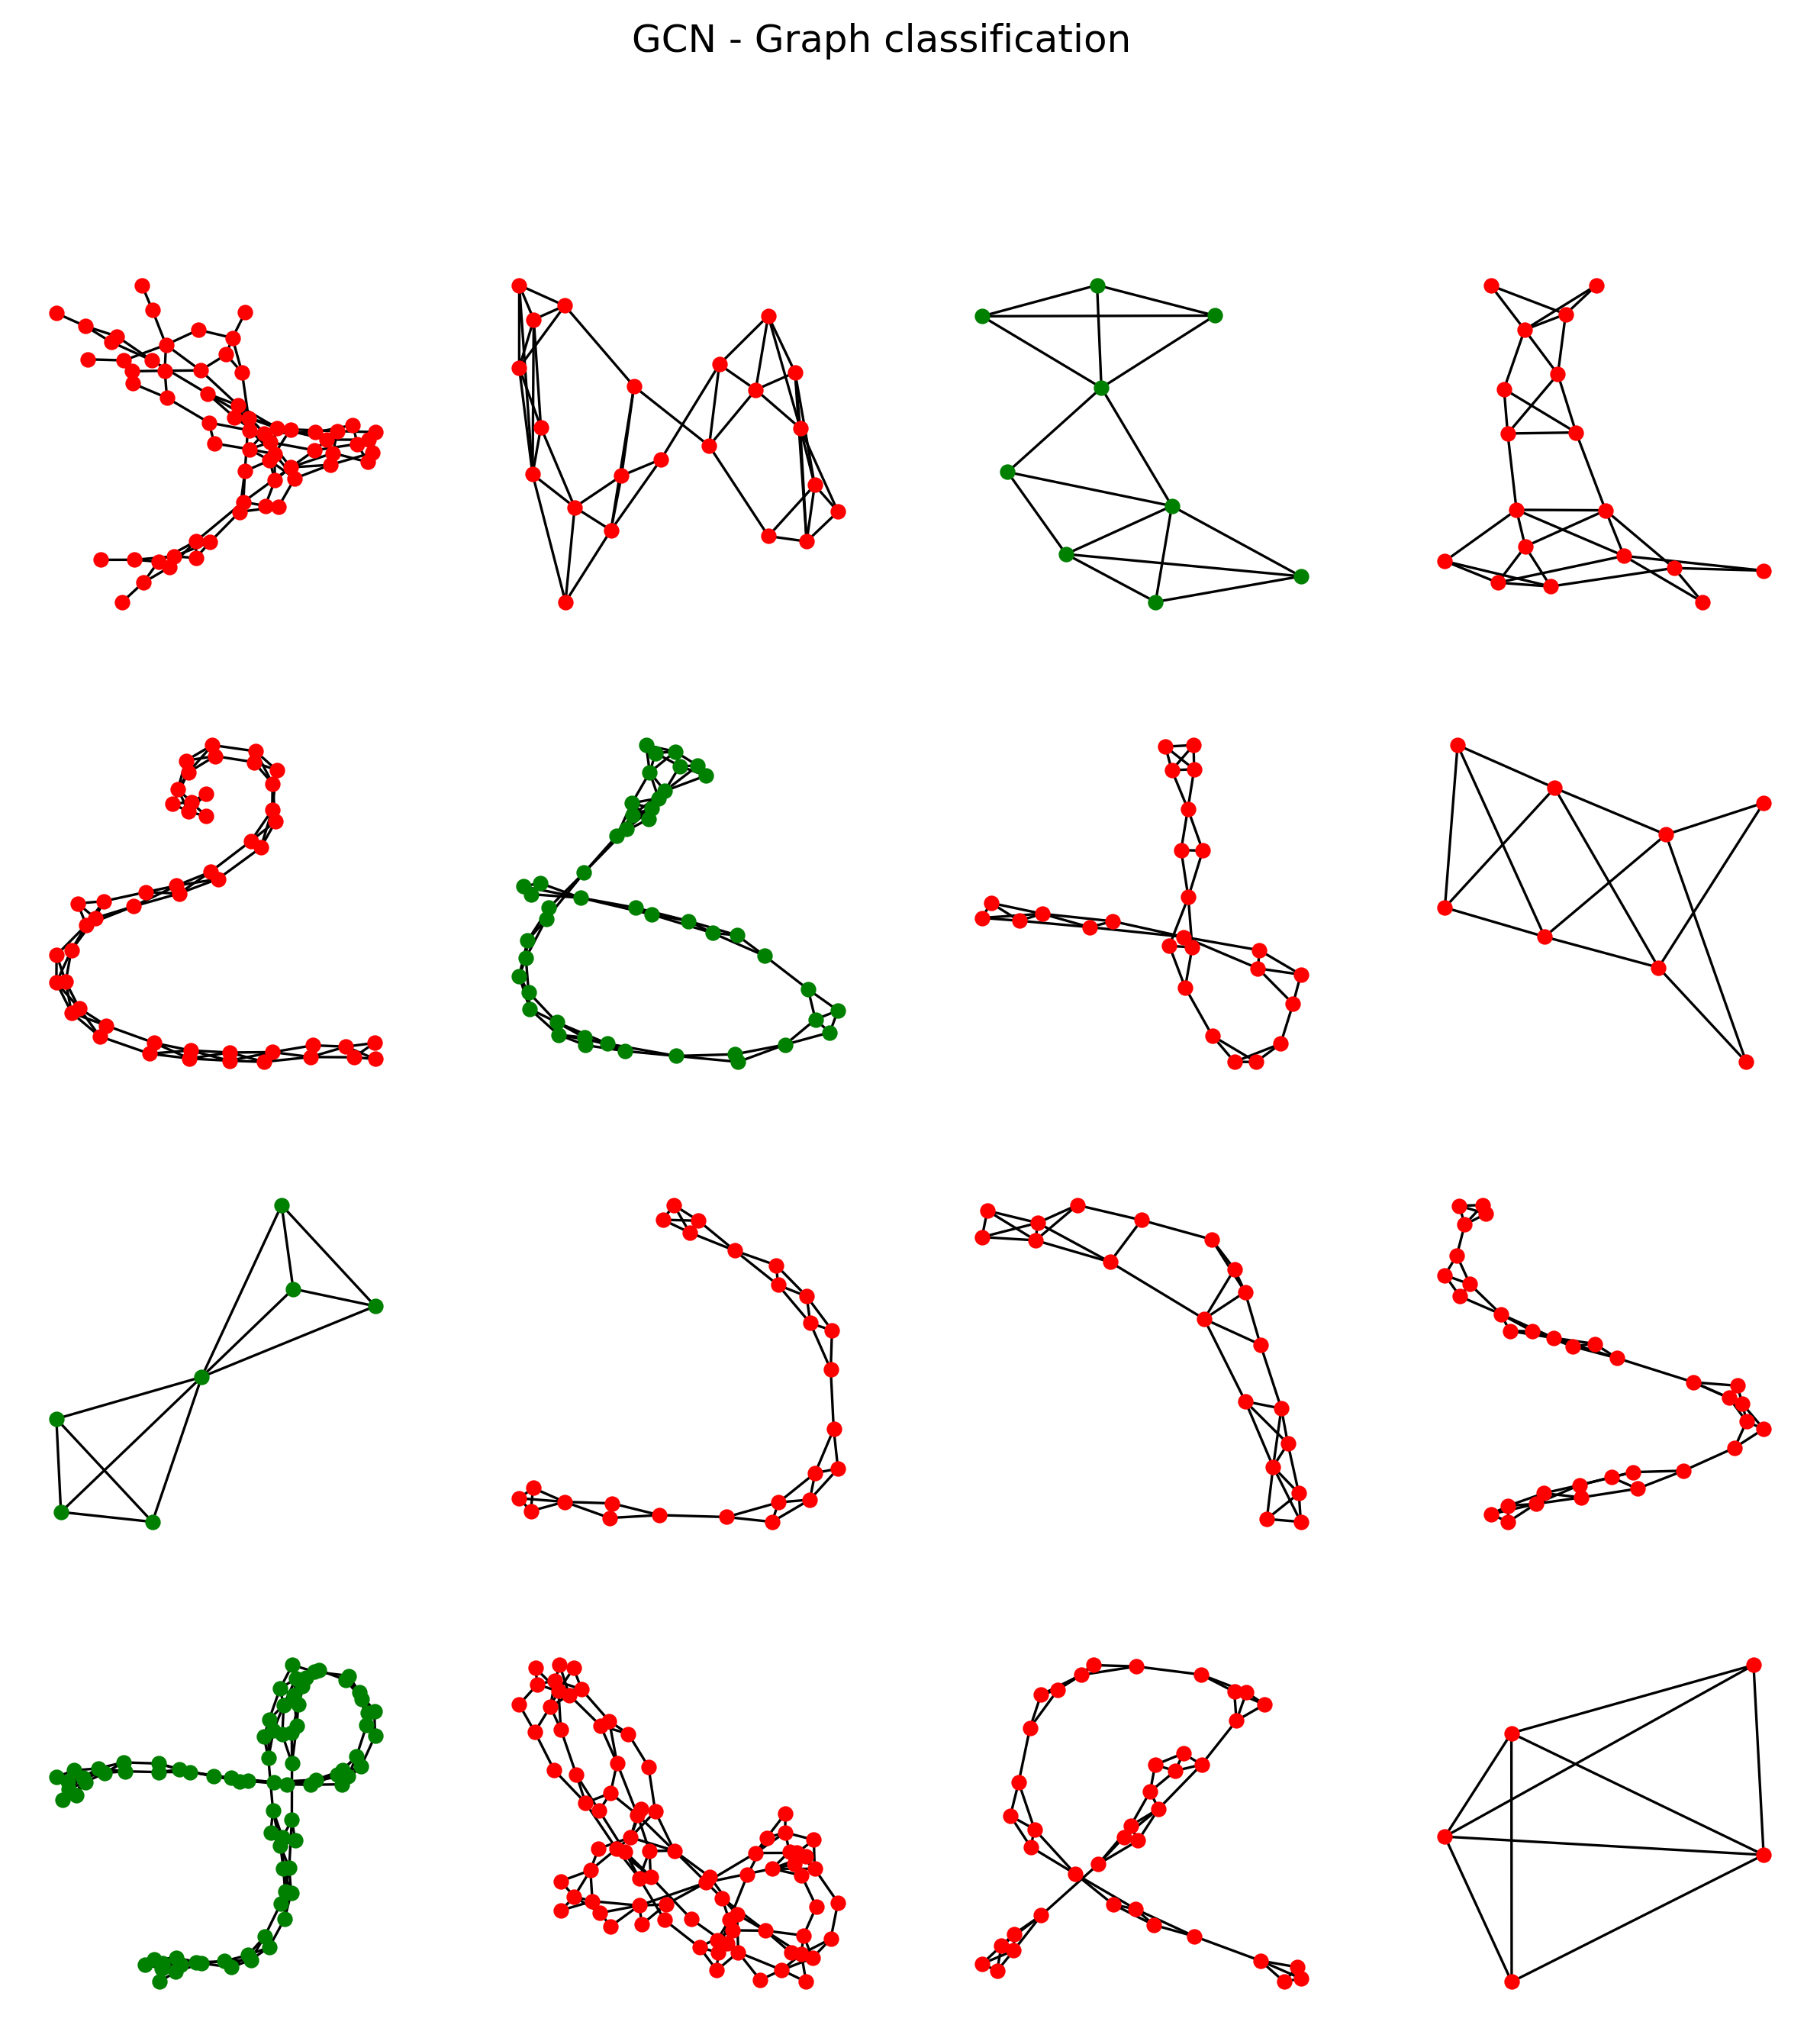

In [161]:
fig, ax = plt.subplots(4, 4, figsize=(10,10))
fig.suptitle('GCN - Graph classification', fontsize=12)

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=15,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

## Graph Classification with GIN

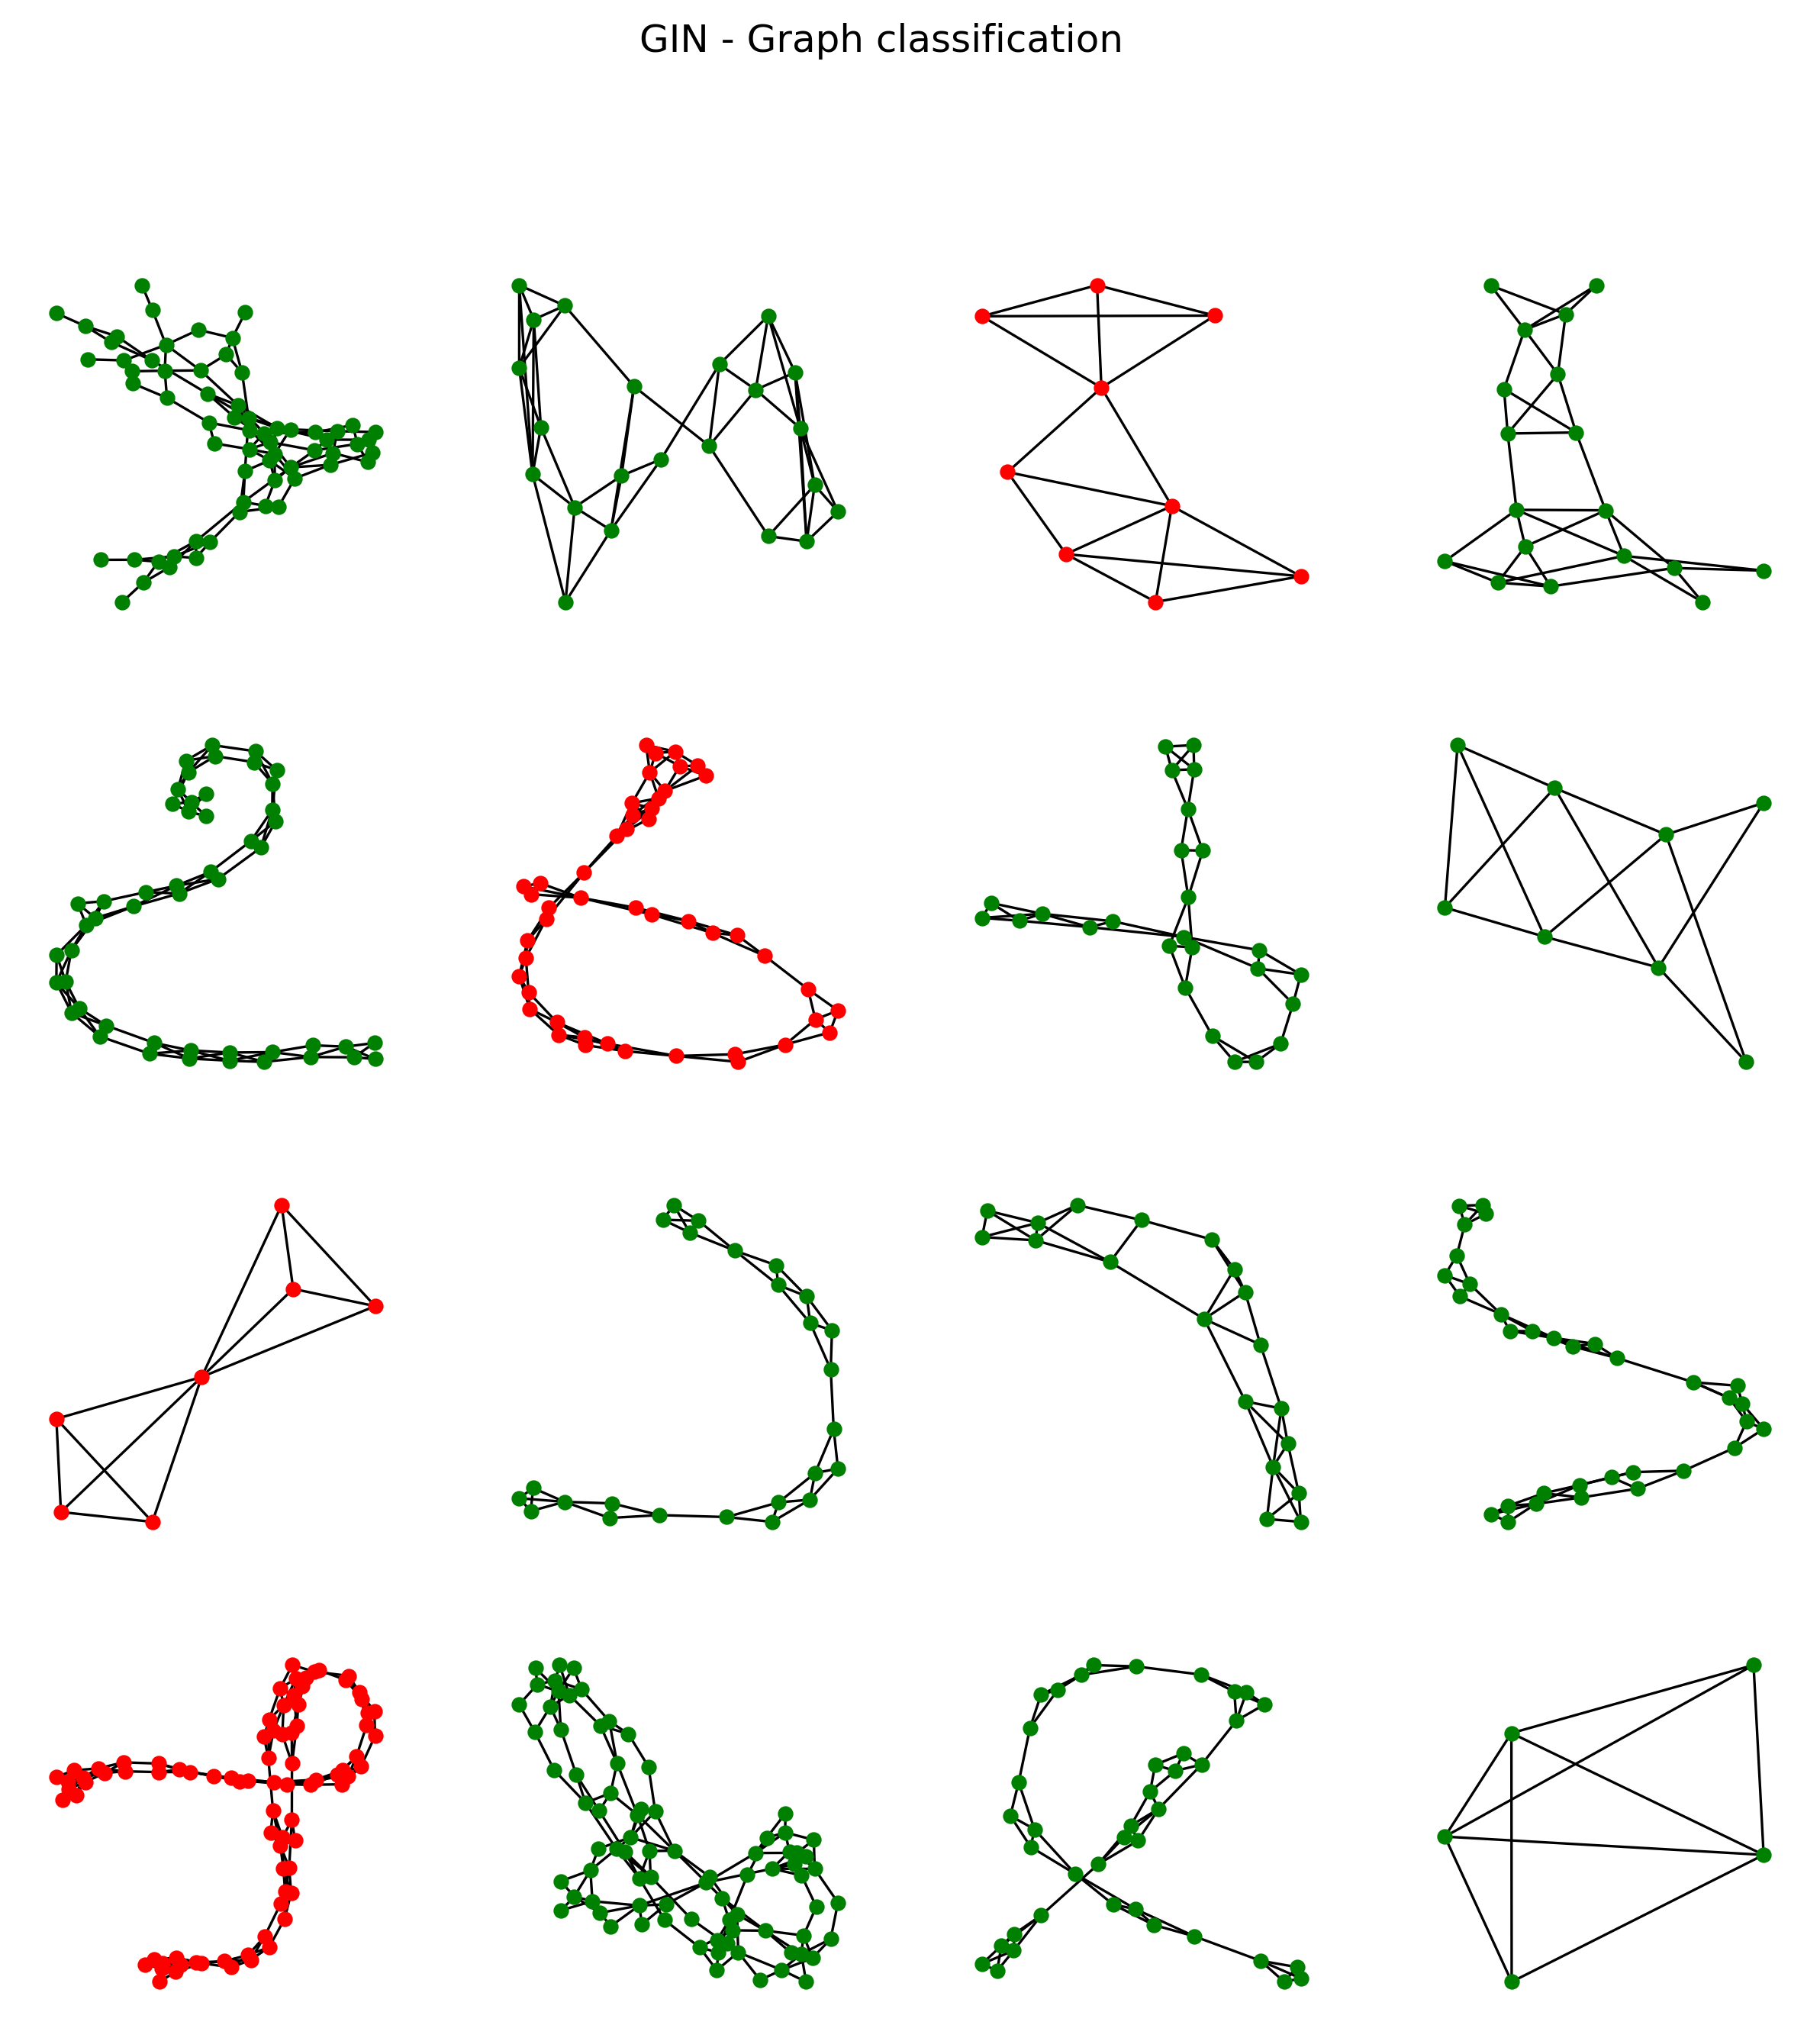

In [162]:
fig, ax = plt.subplots(4, 4, figsize=(10,10))
fig.suptitle('GIN - Graph classification', fontsize=12)

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=15,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

## Comparing the accuracy of GCN and GIN

In [163]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gcn = gcn(data.x, data.edge_index, data.batch)
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')

GCN accuracy:     39.06%
GIN accuracy:     60.94%


## Question 4: What is the accuracy of the GCN model? : 30.06%


## Question 5: What is the accuracy of the  GIN model? and which one is the better for graph classification? : 60.94%, GIN model
